Pronóstico de muertes del Titanic con un estimador lineal (Clasificación)
===

* *30 min* | Última modificación: Abril 8, 2020.

Basado en https://www.tensorflow.org/tutorials/estimator/linear

## Importación de librerías

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf

print(tf.__version__)

#
# Establece el nivel de reporte en
# pantalla de TensorFlow
#
import logging

logger = tf.get_logger().setLevel(logging.ERROR)

2.4.1


## Carga y configuración del dataset

In [2]:
#
#  Carga del dataset
#
dftrain = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
dfeval = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")
y_train = dftrain.pop("survived")
y_eval = dfeval.pop("survived")

#
#  Verificación.
#
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


## Exploración del dataset

In [3]:
#
#  Estadísticos de las columnas numéricas
#
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [4]:
#
#  Cantidad de registros de los datasets
#
dftrain.shape[0], dfeval.shape[0]

(627, 264)

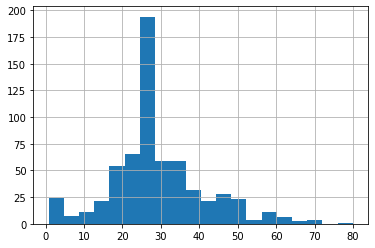

In [5]:
#
#  Histograma de la edad
#
dftrain.age.hist(bins=20)

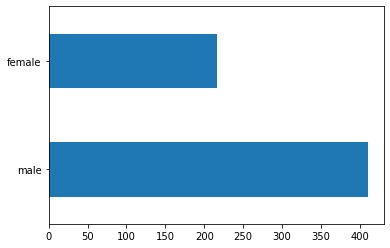

In [6]:
#
#  Distribución de los pasajeros por sexo
#
dftrain.sex.value_counts().plot(kind="barh")

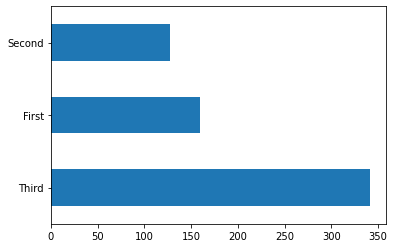

In [7]:
#
#  Distribución de los pasajeros por clase
#
dftrain["class"].value_counts().plot(kind="barh")

Text(0.5, 0, '% survive')

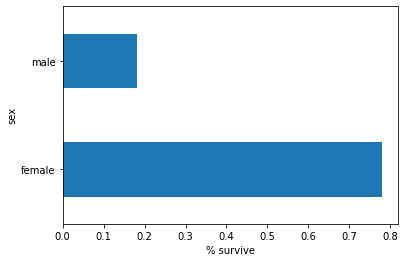

In [8]:
#
#  Distribución de los pasajeros sobrevivientes
#  por sexo
#
pd.concat([dftrain, y_train], axis=1).groupby("sex").survived.mean().plot(
    kind="barh"
).set_xlabel("% survive")

## Preparación de los datos para usar el estimador

In [9]:
CATEGORICAL_COLUMNS = [
    "sex",
    "n_siblings_spouses",
    "parch",
    "class",
    "deck",
    "embark_town",
    "alone",
]
NUMERIC_COLUMNS = ["age", "fare"]


#
#  Se genera una lista que tiene el tipo de cada columna
#
feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary
        )
    )

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(
        tf.feature_column.numeric_column(feature_name, dtype=tf.float32)
    )

In [10]:
example = dict(dftrain.head(1))
class_fc = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(
        "class", ("First", "Second", "Third")
    )
)
print('Feature value: "{}"'.format(example["class"].iloc[0]))
print("One-hot encoded: ", tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

Feature value: "Third"
One-hot encoded:  [[0. 0. 1.]]


In [11]:
NUM_EXAMPLES = len(y_train)


def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(NUM_EXAMPLES)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds

    return input_function


train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [12]:
#
#  Ejemplo de las salidas de la función make_input_fn.
#  Note que una sola llamada genera un batch para el entrenamiento
#
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print("Some feature keys:", list(feature_batch.keys()))
    print()
    print("A batch of class:", feature_batch["class"].numpy())
    print()
    print("A batch of Labels:", label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'First' b'Third' b'Second' b'Third' b'Third' b'Third' b'First' b'Third'
 b'Third' b'Third']

A batch of Labels: [0 0 1 1 0 0 0 0 0 0]


In [13]:
#
#  Batch para la columna edad.
#
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

array([[31.],
       [19.],
       [34.],
       [28.],
       [ 9.],
       [45.],
       [24.],
       [28.],
       [22.],
       [26.]], dtype=float32)

In [14]:
#
#  Batch para la columna gender
#
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(
    feature_batch
).numpy()

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## Creación y entrenamiento del modelo

In [15]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


## Evaluación del modelo

In [16]:
result = linear_est.evaluate(eval_input_fn)
for key in result.keys():
    print("%s: %.3f" % (key, result[key]))

accuracy: 0.739
accuracy_baseline: 0.625
auc: 0.808
auc_precision_recall: 0.742
average_loss: 0.602
label/mean: 0.375
loss: 0.597
precision: 0.857
prediction/mean: 0.220
recall: 0.364
global_step: 200.000


## Exploración de características derivadas

In [17]:
#
#  Combinación de características
#
age_x_gender = tf.feature_column.crossed_column(["age", "sex"], hash_bucket_size=100)

#
#  Entrenamiento
#
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(
    feature_columns=feature_columns + derived_feature_columns
)
linear_est.train(train_input_fn)

#
#  Resultados
#
result = linear_est.evaluate(eval_input_fn)
for key in result.keys():
    print("%s: %.3f" % (key, result[key]))

accuracy: 0.758
accuracy_baseline: 0.625
auc: 0.846
auc_precision_recall: 0.780
average_loss: 0.470
label/mean: 0.375
loss: 0.462
precision: 0.667
prediction/mean: 0.398
recall: 0.707
global_step: 200.000


## Pronóstico

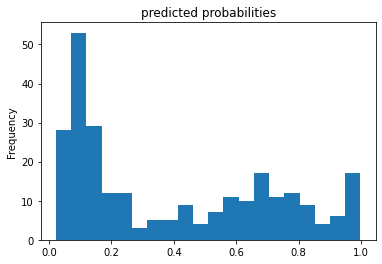

In [18]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred["probabilities"][1] for pred in pred_dicts])

probs.plot(kind="hist", bins=20, title="predicted probabilities")

## Curva ROC

(0.0, 1.05)

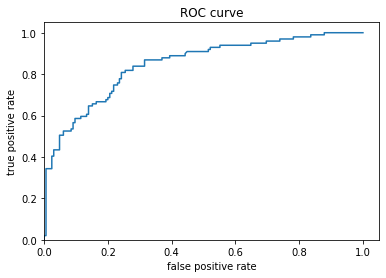

In [19]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.xlim(0,)
plt.ylim(0,)